
# Pré-Processamento: Processamento de Dados e Preparação do Dataset

## Objetivo
  A apartir de um conjunto de dados não tratados referente às receitas de uma loja de desporto, efetuar as associações necessárias, eliminando toda a informação considerada desnecessária para o âmbito do nosso projeto, gerando um dataset final a ser, posteriormente, importado no pré-processamento de dados. 


In [1]:
%pip install pandas
%pip install xlrd
%pip install openpyxl
%pip install unidecode
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
# Use train_test_split in sklearn.cross_validation to split data into train and test sets
from sklearn.model_selection import train_test_split


In [3]:


# Lemos o dataset
df = pd.read_csv('dataset/sales.csv')

# Verificamos o dataset carregado
print(df.head(5))


C:\Users\reidp\AppData\Local\Temp\ipykernel_6860\2804483899.py:2: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset/sales.csv')


  product_id store_id        date  sales  revenue  stock  price promo_type_1  \
0      P0001    S0002  2017-01-02    0.0     0.00    8.0   6.25         PR14   
1      P0001    S0012  2017-01-02    1.0     5.30    0.0   6.25         PR14   
2      P0001    S0013  2017-01-02    2.0    10.59    0.0   6.25         PR14   
3      P0001    S0023  2017-01-02    0.0     0.00    6.0   6.25         PR14   
4      P0001    S0025  2017-01-02    0.0     0.00    1.0   6.25         PR14   

  promo_bin_1 promo_type_2 promo_bin_2  promo_discount_2 promo_discount_type_2  
0         NaN         PR03         NaN               NaN                   NaN  
1         NaN         PR03         NaN               NaN                   NaN  
2         NaN         PR03         NaN               NaN                   NaN  
3         NaN         PR03         NaN               NaN                   NaN  
4         NaN         PR03         NaN               NaN                   NaN  


In [4]:

# Verificamos o período do dataset
def sales_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'dias')
    print(number_of_years, 'anos')
    
sales_duration(df)


1091 dias
2.989041095890411 anos


In [5]:

# Verificamos que cada produto tem vários registos por dia, dado que para cada produto existem mais registos do que o total de dias acima ilustrado, sendo estes
# referentes às diferentes lojas em que foram vendidos. Porém, para efeitos de análise, iremos agrupar as vendas diárias de cada produto em todas as lojas numa só linha.
print(df['product_id'].value_counts().sort_values(ascending=False).head(15))



P0125    140997
P0364    140569
P0261    139651
P0333    139632
P0664    139486
P0390    139332
P0131    139014
P0536    138856
P0499    138228
P0116    137142
P0569    137132
P0372    136738
P0103    135841
P0642    134062
P0129    133990
Name: product_id, dtype: int64


In [6]:


# Verificamos as percentagens de dados em falta
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head()



promo_bin_2              99.696317
promo_discount_2         99.696317
promo_discount_type_2    99.696317
promo_bin_1              86.370028
sales                     6.120647
dtype: float64

In [7]:


# Verificamos a distribuição das colunas de valores de promoção que estão preenchidas
print(df[df['product_id'] == 'P0004']['promo_type_1'].value_counts().sort_values(ascending=False).head(15))



PR14    2092
Name: promo_type_1, dtype: int64


In [8]:


# Verificamos a distribuição das colunas de valores de promoção que estão preenchidas
print(df[df['product_id'] == 'P0004']['promo_type_2'].value_counts().sort_values(ascending=False).head(15))



PR03    2092
Name: promo_type_2, dtype: int64


In [9]:


# Removemos as colunas cujas percentagens de inutilização são evidentemente superiores ao aceitável
df = df.drop(columns=["promo_bin_2", "promo_discount_2", "promo_discount_type_2", "promo_bin_1"])

# Removemos as colunas cuja distribuição é quase 100% para um determinado valor, dado que não terão impacto no modelo
df = df.drop(columns=["promo_type_1","promo_type_2"])
print(df.head(5))



  product_id store_id       date  sales  revenue  stock  price
0      P0001    S0002 2017-01-02    0.0     0.00    8.0   6.25
1      P0001    S0012 2017-01-02    1.0     5.30    0.0   6.25
2      P0001    S0013 2017-01-02    2.0    10.59    0.0   6.25
3      P0001    S0023 2017-01-02    0.0     0.00    6.0   6.25
4      P0001    S0025 2017-01-02    0.0     0.00    1.0   6.25


In [10]:


# Verificamos novamente as percentagens de dados em falta
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head()



sales         6.120647
revenue       6.120647
stock         6.120647
price         2.940045
product_id    0.000000
dtype: float64

In [11]:


# Agrupamos as vendas diárias por produto. 
# Para manter o preço diário de cada produto, como este pode variar de loja para loja, inferimos a média do preço diário de cada produto entre todas as lojas.
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['week'] = df.date.dt.isocalendar().week
df2 = df.groupby(["product_id", "year", "month", "week"]).agg({'sales': ['sum'], 'revenue': ['sum'], 'stock': ['sum'], 'price': ['mean']}).reset_index()
df2.columns = df2.columns.droplevel(1)
df2['date'] = df2.apply(lambda row: datetime.strptime(f'{row.year} {row.week} 1', '%G %V %u'), axis=1)

print(df2.head(15))



   product_id  year  month  week  sales  revenue   stock    price       date
0       P0001  2017      1     1   24.0   127.17  1318.0  6.25000 2017-01-02
1       P0001  2017      1     2   21.0   112.97  1174.0  6.31713 2017-01-09
2       P0001  2017      1     3   15.0    82.65  1040.0  6.50000 2017-01-16
3       P0001  2017      1     4    8.0    44.08   961.0  6.50000 2017-01-23
4       P0001  2017      1     5    2.0    11.02   266.0  6.50000 2017-01-30
5       P0001  2017      2     5   10.0    55.10   638.0  6.50000 2017-01-30
6       P0001  2017      2     6   18.0    99.18   804.0  6.50000 2017-02-06
7       P0001  2017      2     7    5.0    27.55   742.0  6.50000 2017-02-13
8       P0001  2017      2     8    2.0    11.02   704.0  6.50000 2017-02-20
9       P0001  2017      2     9    1.0     5.51   195.0  6.50000 2017-02-27
10      P0001  2017      3     9    6.0    33.06   466.0  6.50000 2017-02-27
11      P0001  2017      3    10   11.0    60.60   607.0  6.50000 2017-03-06

In [12]:

# Verificamos novamente a quantidade de registos por produto, sendo que este valor deverá diminuir drasticamente face à análise igual feita anteriormente
# Assim, a quantidade agora deverá ser igual para todos os produtos, tendo como valor o total de dias do dataset previamente visto.
print(df2['product_id'].value_counts().sort_values(ascending=False).head(15))



P0001    186
P0536    186
P0611    186
P0609    186
P0608    186
P0602    186
P0599    186
P0591    186
P0590    186
P0587    186
P0585    186
P0583    186
P0579    186
P0574    186
P0572    186
Name: product_id, dtype: int64


In [13]:

# Exportamos o Dataset já agrupado caso seja pretendido analisar os dados ao pormenor. (opcional)
#df2.to_csv('dataset/sales_grouped.csv')



In [14]:


# Verificamos novamente as percentagens de dados em falta, já com as vendas agrupadas
percent_missing = df2.isnull().sum() * 100 / len(df2)
percent_missing.sort_values(ascending=False).head()



price         2.041694
product_id    0.000000
year          0.000000
month         0.000000
week          0.000000
dtype: float64

In [15]:


# Utilizamos pyplot em matplotlib para criar plot histograms
import matplotlib.pyplot as plt

def plot_histogram(x):
    plt.hist(x, color='gray', alpha=0.5)
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

    

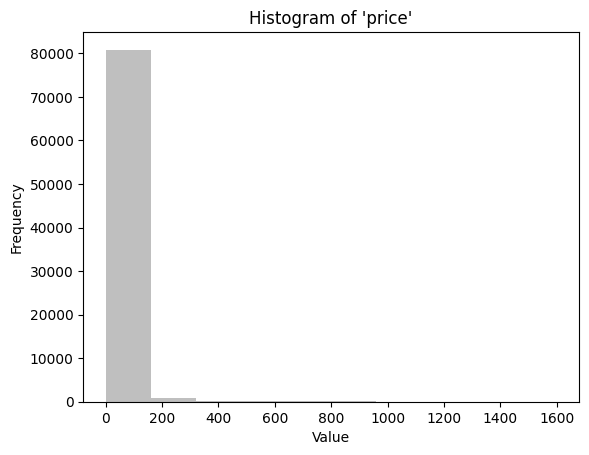

In [16]:

plot_histogram(df2['price'])


In [17]:


# Dividimos o dataframe por produto, dado que irá ser treinado um modelo de previsão para cada um.
dfByProdList = df2.groupby("product_id")

print(len(dfByProdList))

    

649


In [18]:

# Para efeitos de análise, iremos inicialmente começar por criar um modelo somente para um produto.
product_df = dfByProdList.get_group('P0001')
print(product_df.head())



  product_id  year  month  week  sales  revenue   stock    price       date
0      P0001  2017      1     1   24.0   127.17  1318.0  6.25000 2017-01-02
1      P0001  2017      1     2   21.0   112.97  1174.0  6.31713 2017-01-09
2      P0001  2017      1     3   15.0    82.65  1040.0  6.50000 2017-01-16
3      P0001  2017      1     4    8.0    44.08   961.0  6.50000 2017-01-23
4      P0001  2017      1     5    2.0    11.02   266.0  6.50000 2017-01-30


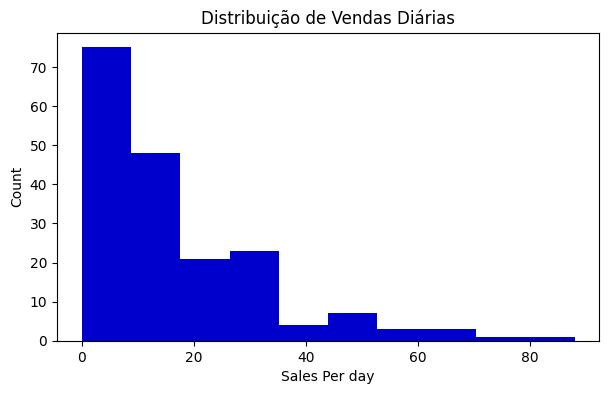

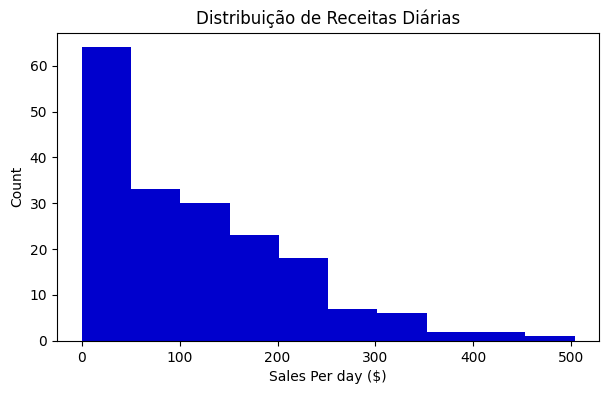

In [19]:


# Verificamos a distribuição de vendas diárias para este produto
def sales_per_day(product_sales_data):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(product_sales_data.sales, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day",
           ylabel = "Count",
           title = "Distribuição de Vendas Diárias")
    
def revenue_per_day(product_sales_data):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(product_sales_data.revenue, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day ($)",
           ylabel = "Count",
           title = "Distribuição de Receitas Diárias")
    
sales_per_day(product_df)
revenue_per_day(product_df)



In [20]:


# Verificamos a média de vendas e receitas diárias
avg_monthly_sales = product_df.sales.mean()
avg_monthly_revenue = product_df.revenue.mean()
print(f"Média de vendas diárias: {avg_monthly_sales}")
print(f"Média de receitas diárias: ${avg_monthly_revenue}")



Média de vendas diárias: 15.96236559139785
Média de receitas diárias: $113.59376344086022


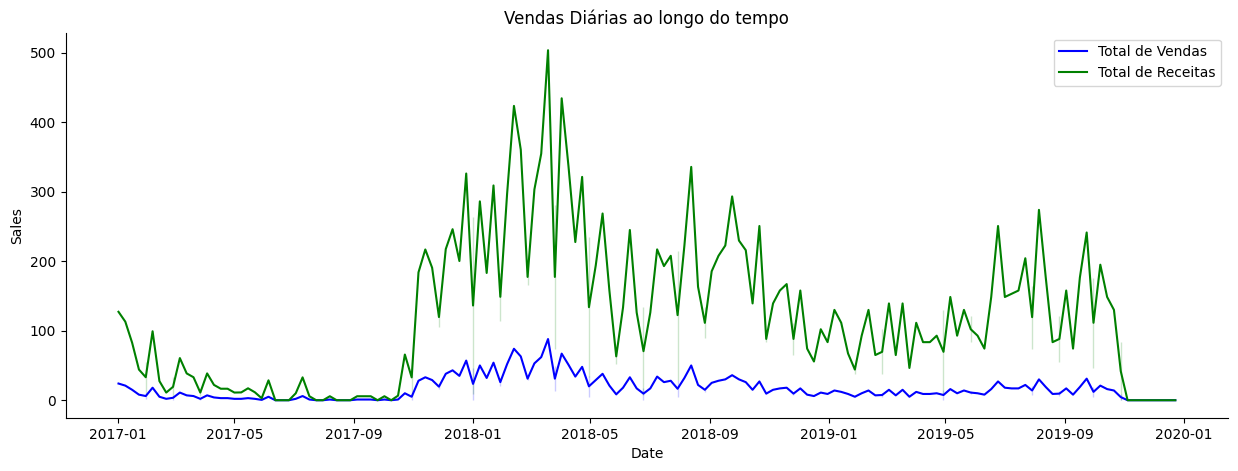

In [21]:

def time_plot(data, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x = 'date', y = 'sales', data=data, ax=ax, color='blue', label='Total de Vendas')
    sns.lineplot(x = 'date', y = 'revenue', data=data, ax=ax, color='green', label='Total de Receitas') 
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()
    
# Verificamos o histórico de vendas diárias do produto ao longo do tempo
time_plot(product_df, 'Vendas Diárias ao longo do tempo')


In [22]:
# Deteção de outliers recorrendo a Tukey IQR
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values


In [23]:

# Verificamos se existem outliers a ter em consideração
tukey_indices1, tukey_values1 = find_outliers_tukey(product_df['sales'])
tukey_indices2, tukey_values2 = find_outliers_tukey(product_df['revenue'])
print(np.sort(tukey_values1))
print(np.sort(tukey_values2))




[53. 54. 57. 62. 63. 67. 74. 88.]
[423.28 434.22 503.36]


In [24]:


# Verificamos se existem valores em falta para este produto
percent_missing = product_df.isnull().sum()
percent_missing.sort_values(ascending=False).head()



product_id    0
year          0
month         0
week          0
sales         0
dtype: int64

In [25]:




product_df1 = product_df.copy()

# Create a new column called 'prev_sales' that lags the 'sales' column by one day
product_df1['prev_sales'] = product_df1['sales'].shift(1)
product_df1['prev_revenue'] = product_df1['revenue'].shift(1)

# Fill the first row of the 'prev_sales' column with 0
product_df1['prev_sales'] = product_df1['prev_sales'].fillna(0)
product_df1['prev_revenue'] = product_df1['prev_revenue'].fillna(0)
product_df1 = product_df1.astype({'revenue':'int', 'prev_revenue':'int'})

# Reset the index of the dataframe
# Create a new column called 'prev_quarter_sales' that lags the 'sales' column by one quarter
#product_df1['prev_quarter_sales'] = product_df1'year', 'quarter'])['sales'].rolling(3).sum()

# Fill the first row of the 'prev_quarter_sales' column with 0
#product_df1['prev_quarter_sales'] = product_df1['prev_quarter_sales'].fillna(0)


# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=1)
# # X_train = np.array(X_train).reshape((-1, 1))
# # X_test = np.array(X_test).reshape((-1, 1))

# print(product_df1.head())



In [26]:


X = product_df1.drop(['revenue', 'date', 'product_id','sales','stock','price','prev_revenue'], 1)
y = product_df1.sales
X2 = product_df1.drop(['revenue', 'date', 'product_id','sales','stock','price','prev_sales'], 1)
y2 = product_df1.revenue

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7, random_state=1)
# X_train = np.array(X_train).reshape((-1, 1))
# X_test = np.array(X_test).reshape((-1, 1))

print(product_df1.head())



  product_id  year  month  week  sales  revenue   stock    price       date  \
0      P0001  2017      1     1   24.0      127  1318.0  6.25000 2017-01-02   
1      P0001  2017      1     2   21.0      112  1174.0  6.31713 2017-01-09   
2      P0001  2017      1     3   15.0       82  1040.0  6.50000 2017-01-16   
3      P0001  2017      1     4    8.0       44   961.0  6.50000 2017-01-23   
4      P0001  2017      1     5    2.0       11   266.0  6.50000 2017-01-30   

   prev_sales  prev_revenue  
0         0.0             0  
1        24.0           127  
2        21.0           112  
3        15.0            82  
4         8.0            44  


C:\Users\reidp\AppData\Local\Temp\ipykernel_6860\2375898180.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = product_df1.drop(['revenue', 'date', 'product_id','sales','stock','price','prev_revenue'], 1)
C:\Users\reidp\AppData\Local\Temp\ipykernel_6860\2375898180.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X2 = product_df1.drop(['revenue', 'date', 'product_id','sales','stock','price','prev_sales'], 1)


In [27]:


# The total number of features have grown substantially after dummying and adding interaction terms
print(X.shape)
print(X2.shape)
print(y.shape)
print(y2.shape)
print(X_train.shape)
print(X2_train.shape)
print(y_train.shape)
print(y2_train.shape)



(186, 4)
(186, 4)
(186,)
(186,)
(130, 4)
(130, 4)
(130,)
(130,)


In [28]:


# Function to build model and find model performance
from numpy import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def find_model_perf(X_train, y_train, X_test, y_test):
    model = LogisticRegression(solver='lbfgs', max_iter=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute the MSE
    mse = mean_squared_error(y_test, y_pred)

    # Compute the RMSE
    rmse = sqrt(mse)

    # Compute the MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Compute the R^2 score
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

    # Y_hat = [x[1] for x in model.predict(X_test)]
    # auc = roc_auc_score(Y_test, Y_hat)
    
    



In [89]:

from datetime import datetime

XArima = product_df1.date
yArima = product_df1.sales
XArima_train , XArima_test,yArima_train,yArima_test = train_test_split(XArima, yArima, train_size=0.7, random_state=None)



In [90]:
print(XArima[0])

2017-01-02 00:00:00


In [91]:
from statsmodels.tsa.arima.model import ARIMA

def find_model_perf_arima(X_train,y_train,X_test,y_test):

    model = ARIMA(X_train, y_train)
    model = model.fit()
    y_pred = model.predict(X_test)

    # Compute the MSE
    mse = mean_squared_error(y_test, y_pred)

    # Compute the RMSE
    rmse = sqrt(mse)

    # Compute the MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Compute the R^2 score
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [92]:


# Find performance of model using preprocessed data
find_model_perf_arima(XArima_train, yArima_train, XArima_test, yArima_test)



C:\Users\reidp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\reidp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\reidp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('<M8[ns]') and dtype('O')

In [30]:

# Find performance of model using preprocessed data
find_model_perf(X2_train, y2_train, X2_test, y2_test)


C:\Users\reidp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RMSE: 95.73176812621519
MAE: 63.5
R2 Score: 0.08742314209069513


In [31]:


modelResults = pd.DataFrame(columns=["product_id", "mse_sales", "mse_revenue", "rmse_sales", "rmse_revenue", "r2_sales", "r2_revenue"])

# Iteramos a lista de dataframes
for name, group in dfByProdList:
    # Create a new column called 'prev_sales' that lags the 'sales' column by one day
    group['prev_sales'] = group['sales'].shift(1)
    group['prev_revenue'] = group['revenue'].shift(1)

    # Fill the first row of the 'prev_sales' column with 0
    group['prev_sales'] = group['prev_sales'].fillna(0)
    group['prev_revenue'] = group['prev_revenue'].fillna(0)
    
    group = group.astype({'revenue':'int', 'prev_revenue':'int'})

    X_sales = group.drop(['revenue', 'date', 'product_id','sales','stock','price','prev_revenue'], 1)
    y_sales = group.sales
    X_revenue = group.drop(['revenue', 'date', 'product_id','sales','stock','price','prev_sales'], 1)
    y_revenue = group.revenue

    X_train_sales, X_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, y_sales, train_size=0.7, random_state=1)
    X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue = train_test_split(X_revenue, y_revenue, train_size=0.7, random_state=1)

    model = LogisticRegression(solver='lbfgs', max_iter=100)
    model.fit(X_train_sales, y_train_revenue)
    y_pred_sales = model.predict(X_test_sales)

    model2 = LogisticRegression(solver='lbfgs', max_iter=100)
    model2.fit(X_train_sales, y_train_revenue)
    y_pred_revenue = model2.predict(X_test_revenue)

    # Compute the MSE
    mse_sales = mean_squared_error(y_test_sales, y_pred_sales)
    mse_revenue = mean_squared_error(y_test_revenue, y_pred_revenue)

    # Compute the RMSE
    rmse_sales = sqrt(mse_sales)
    rmse_revenue = sqrt(mse_revenue)

    # Compute the MAE
    mae_sales = mean_absolute_error(y_test_sales, y_pred_sales)
    mae_revenue = mean_absolute_error(y_test_revenue, y_pred_revenue)

    # Compute the R^2 score
    r2_sales = r2_score(y_test_sales, y_pred_sales)
    r2_revenue = r2_score(y_test_revenue, y_pred_revenue)

    modelResults = modelResults.append({"product_id": name, "rmse_sales": rmse_sales, "rmse_revenue": rmse_revenue, "mae_sales": mae_sales, "mae_revenue": mae_revenue,
        "r2_sales": r2_sales, "r2_revenue": r2_revenue}, ignore_index=True)
    


C:\Users\reidp\AppData\Local\Temp\ipykernel_9624\3355640037.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_sales = group.drop(['revenue', 'date', 'product_id','sales','stock','price','prev_revenue'], 1)
C:\Users\reidp\AppData\Local\Temp\ipykernel_9624\3355640037.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_revenue = group.drop(['revenue', 'date', 'product_id','sales','stock','price','prev_sales'], 1)
C:\Users\reidp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/p

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- prev_revenue
Feature names seen at fit time, yet now missing:
- prev_sales


In [ ]:


print(modelResults.head())
